## Study of the MNIST dataset with neural networks

The goal of this project is not only to classify the images, but to create some. But we will start simply with classification, and then adapt it to something more ambitious. 

In [3]:
import torch
# from torchvision import datasets, transforms # not compatible with Python 3.13
import struct
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fancy_package import *

In [4]:
from torch.utils.data import Dataset, DataLoader

class MNISTDataset(Dataset):
    train_images_path = "data/train-images-idx3-ubyte"
    train_labels_path = "data/train-labels-idx1-ubyte"
    test_images_path = "data/t10k-images-idx3-ubyte"
    test_labels_path = "data/t10k-labels-idx1-ubyte"
    
    @staticmethod
    def load_images(path:str):
        with open(path, "rb") as f:
            magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
            data = f.read()
            images = torch.frombuffer(data, dtype=torch.uint8)
            images = images.view(num, 1, rows, cols) # the 1 here is the number of channels. this is the shape expected by Conv2d layer for torch.nn
            images = images / 255.0
        return images
    
    @staticmethod
    def load_labels(path:str):
        with open(path, "rb") as f:
            magic, num = struct.unpack(">II", f.read(8))
            data = f.read()
            labels = torch.frombuffer(data, dtype=torch.uint8)
            labels = labels.view(num)
        return labels
    
    def __init__(self, train:bool = True):
        if train:
            images_path = MNISTDataset.train_images_path
            labels_path = MNISTDataset.train_labels_path
        else:
            images_path = MNISTDataset.test_images_path
            labels_path = MNISTDataset.test_labels_path
        
        self.images = MNISTDataset.load_images(images_path)
        self.labels = MNISTDataset.load_labels(labels_path)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index:int):
        return self.images[index], self.labels[index]
    
    def plot(self, idx:int = None):
        if idx is None:
            idx = np.random.randint(0, len(self.images))
        image, label = self[idx]
        image = image[0] # channel 0 --> we are in greyscale, there is only only channel anyway
        plt.figure(figsize=(3, 3))
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label.item()}")
        plt.axis('off')
        plt.show()

/tmp/ipykernel_7594/3684466267.py:14: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:1577.)
  images = torch.frombuffer(data, dtype=torch.uint8)


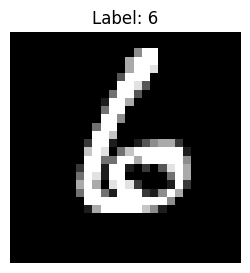

In [5]:
train_dataset = MNISTDataset(train=True)
test_dataset = MNISTDataset(train=False)

train_dataset.plot()

___
## Classification with CNNs

In [6]:

class MnistCnn(nn.Module):
    
    epochs = 10
    
    def __init__(self):
        super(MnistCnn, self).__init__()
        
        # let' choose the device
        with Message("Detecting the device:").tab():
            if torch.cuda.is_available():
                self.device = torch.device("cuda")
                Message.print("Running on GPU...")
            else:
                self.device = torch.device("cpu")
                Message.print("Running on CPU...")
                
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) # output 32x28x28
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output 32x14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # kernel size 2 means we take 2x2 blocks and take the max of each block, stride=2 means we move 2 pixels at a time
        
        # switch to connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128) # we will flatten the data, hence the 64 * 7 * 7
        self.fc2 = nn.Linear(128, 10) # 10 possible outputs (0-9)
        
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        # flatten the data
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
    def fit(self, dataset): # match sklearn format and other libraries
        self.train() # tell the model we are training
        
        dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
        
        with Message("Training the neural network...").tab():
            for epoch in ProgressBar(list(range(self.epochs))):
                epoch_loss = 0
                for X_batch, y_batch in dataloader:
                    # move the data
                    X_batch = X_batch.to(self.device)
                    y_batch = y_batch.to(self.device)
                    
                    self.optimizer.zero_grad() # reset the gradients
                    outputs = self.forward(X_batch)
                    loss = self.criterion(outputs, y_batch)
                    
                    # update the wieghts base don the value of the loss
                    loss.backward()
                    self.optimizer.step() # gradient descent
                    epoch_loss += loss.item() * len(X_batch) # total loss of the epoch should be ad average
                epoch_loss /= len(dataset) # average loss of the epoch
                
                if epoch % (self.epochs // 10) == 0:
                    ProgressBar.par()
                    ProgressBar.print(f"Epoch [{epoch+1}/{self.epochs}]: loss={epoch_loss:.4f}")
        
        # exit train mode
        self.eval()
        
    
    def predict_proba(self, X):
        X = X.to(self.device)
        with torch.no_grad(): # makes prediction faster, thi means no need to compute the gradients now
            outputs = self.forward(X)
            return F.softmax(outputs, dim=1) # probabilities for each class (0-9)
        
    def predict(self, X):
        probas = self.predict_proba(X)
        return torch.argmax(probas, dim=1)
    
    def score(self, X, y):
        preds = self.predict(X)
        y = y.to(self.device)
        return (preds == y).float().mean().item()

In [7]:
model = MnistCnn()
model.fit(train_dataset)
score = model.score(test_dataset.images, test_dataset.labels)
Message(f"Accuracy: {score:.1%}")

[i] Detecting the device:
 > Running on CPU...
[i] Training the neural network...
 > [00%] Time remaining: \          
 > Epoch [1/10]: loss=0.1834
 > [10%] Time remaining: 00:04:20          
 > Epoch [2/10]: loss=0.0514
 > [20%] Time remaining: 00:03:46          
 > Epoch [3/10]: loss=0.0361
 > [30%] Time remaining: 00:03:09          
 > Epoch [4/10]: loss=0.0266
 > [40%] Time remaining: 00:02:40          
 > Epoch [5/10]: loss=0.0205
 > [50%] Time remaining: 00:02:14          
 > Epoch [6/10]: loss=0.0168
 > [60%] Time remaining: 00:01:48          
 > Epoch [7/10]: loss=0.0125
 > [70%] Time remaining: 00:01:22          
 > Epoch [8/10]: loss=0.0111
 > [80%] Time remaining: 55.417s          
 > Epoch [9/10]: loss=0.0083
 > [90%] Time remaining: 28.216s          
 > Epoch [10/10]: loss=0.0080
 > [%]  Done!                                                  
[i] Accuracy: 99.0%


Wonderful! Let's try it on one image.

True label: 0
Predicted label: 0


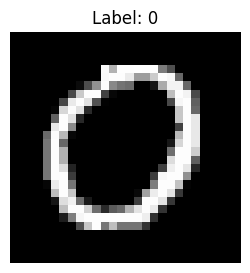

In [8]:
idx = np.random.randint(0, len(test_dataset))
image = test_dataset.images[idx]
label = test_dataset.labels[idx]

# we need to add a batch dimension to the image to pass it along to the model
image = image.unsqueeze(0) # add a batch dimension

prediction = model.predict(image)
print(f"True label: {label.item()}")
print(f"Predicted label: {prediction.item()}")

test_dataset.plot(idx)

___
## Image generation with Autoencoders

In [22]:
class Autoencoder(nn.Module):
    
    latent_space_dim = 3 # good for plotting
    
    # -------------------------- #
    # !-- Classical NN stuff --! #
    # -------------------------- #
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Device
        with Message("Detecting the device:").tab():
            if torch.cuda.is_available():
                self.device = torch.device("cuda")
                Message.print("Running on GPU...")
            else:
                self.device = torch.device("cpu")
                Message.print("Running on CPU...")
        
        # Encoder (CNN)
        self.encoder_conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Output: 32x28x28
        self.encoder_pool1 = nn.MaxPool2d(2, 2)  # Output: 32x14x14
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output: 64x14x14
        self.encoder_pool2 = nn.MaxPool2d(2, 2)  # Output: 64x7x7
        self.fc1 = nn.Linear(64 * 7 * 7, self.latent_space_dim)  # Flatten and map to 2D latent space
        
        # Decoder (Fully connected layers)
        self.fc2 = nn.Linear(self.latent_space_dim, 64 * 7 * 7)  # Mapping from 2D to 64 * 7 * 7
        self.decoder_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1)  # Output: 32x7x7
        self.decoder_upsample1 = nn.Upsample(scale_factor=2)  # Output: 32x14x14
        self.decoder_conv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)  # Output: 1x14x14
        self.decoder_upsample2 = nn.Upsample(scale_factor=2)  # Output: 1x28x28
        
        # latent space stuff for generation
        self.latents = None
        self.labels = None
        self.centroids = None
        self.centroids_labels = None
        self.centroids_std = None
        
        # model to device --> setup optimizer
        self.to(self.device)
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()
        
    
    def forward(self, x):
        # Encoder
        x = self.encoder_conv1(x)
        x = F.relu(x)
        x = self.encoder_pool1(x)
        
        x = self.encoder_conv2(x)
        x = F.relu(x)
        x = self.encoder_pool2(x)
        
        x = torch.flatten(x, start_dim=1)  # Flatten the feature map
        latent = self.fc1(x)  # Encode to 2D latent space
        
        # Decoder
        x = self.fc2(latent)  # Map back to 64 * 7 * 7
        x = x.view(-1, 64, 7, 7)  # Reshape to match the input shape of the conv layer
        
        x = self.decoder_conv1(x)
        x = F.relu(x)
        x = self.decoder_upsample1(x)  # Upsample to 14x14
        
        x = self.decoder_conv2(x)
        x = F.relu(x)
        x = self.decoder_upsample2(x)  # Upsample to 28x28
        
        return x


    def fit(self, dataset, epochs=10, batch_size=64):
        self.train()  # Set the model to training mode
        
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        criterion = nn.MSELoss() # we compare directly the output of the decoder with the input of the encoder
        
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        with Message("Training the autoencoder...").tab():
            for epoch in ProgressBar(list(range(epochs))):
                epoch_loss = 0
                for X_batch, _ in dataloader:
                    
                    # Move data to the device
                    X_batch = X_batch.to(self.device)  
                    
                    optimizer.zero_grad()
                    # Forward pass
                    output = self.forward(X_batch)
                    # Compute loss (mean squared error)
                    loss = criterion(output, X_batch)
                    # Backward pass
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item() * len(X_batch)  # Accumulate loss
                epoch_loss /= len(dataset)  # Average loss for the epoch
                if epochs < 10 or epoch % (epochs // 10) == 0:
                    ProgressBar.par()
                    ProgressBar.print(f"Epoch [{epoch+1}/{epochs}]: loss={epoch_loss:.4f}")
        # Exit training mode
        self.eval()
        
        with Message("Computing latent space...").tab():
            self._compute_latent(dataset, batch_size=batch_size)
            self._compute_centroids()
            
            
        
    def save(self):
        torch.save(self.state_dict(), "data/autoencoder.pth")
        Message("Model saved to autoencoder.pth")
        
    def load(self):
        self.load_state_dict(torch.load("data/autoencoder.pth"))
        Message("Model loaded from autoencoder.pth")
        self.eval()
        
        
    # -------------------------------------- #
    # !-- Autoencoder & image generation --! #
    # -------------------------------------- #
    
    def encode(self, X:torch.Tensor) -> torch.Tensor:
        """
        Note: you cannot pass the whole dataset at once, you don't have enough RAM, this will make everything crash!
        
        Args:
            X (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28).
        Returns:
            torch.Tensor: Encoded tensor of shape (batch_size, 2).
        """
        X = X.to(self.device)
        with torch.no_grad():
            x = self.encoder_conv1(X)
            x = F.relu(x)
            x = self.encoder_pool1(x)

            x = self.encoder_conv2(x)
            x = F.relu(x)
            x = self.encoder_pool2(x)

            x = torch.flatten(x, start_dim=1)
            latent = self.fc1(x)
        return latent.cpu()
    
    def decode(self, latent:torch.Tensor) -> torch.Tensor:
        """
        Args:
            latent (torch.Tensor): Encoded tensor of shape (batch_size, 2).
        Returns:
            torch.Tensor: Decoded tensor of shape (batch_size, 1, 28, 28).
        """
        latent = latent.to(self.device)
        with torch.no_grad():
            x = self.fc2(latent)
            x = x.view(-1, 64, 7, 7)

            x = self.decoder_conv1(x)
            x = F.relu(x)
            x = self.decoder_upsample1(x)

            x = self.decoder_conv2(x)
            x = F.relu(x)
            x = self.decoder_upsample2(x)
        return x.cpu()
    
    def _compute_latent(self, dataset, batch_size=64):
        """
        Args:
            dataset (MNISTDataset): Dataset object.
            batch_size (int): Batch size for DataLoader.
        Returns:
            torch.Tensor: Latent representation of the dataset.
            torch.Tensor: Corresponding labels.
        """
        assert self.latents is None, "Latents already computed!"
        self.eval()
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        latents = []
        labels = []
        
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                latent = self.encode(X_batch)
                latents.append(latent)
                labels.append(y_batch)
        
        self.latents, self.labels = torch.cat(latents), torch.cat(labels)
        
    
    def _compute_centroids(self):
        assert self.latents is not None, "Latents not computed yet! Call _compute_latent first."
        assert self.centroids is None, "Centroids already computed!"
        
        # let's compute the centroids of the clusters with torch only
        self.centroids_labels = torch.unique(self.labels)
        self.centroids = torch.zeros((len(self.centroids_labels), self.latents.shape[1]))
        self.centroids_std = torch.zeros((len(self.centroids_labels), self.latents.shape[1]))
        
        for i, label in enumerate(self.centroids_labels):
            mask = self.labels == label
            self.centroids[i] = torch.mean(self.latents[mask], dim=0)
            self.centroids_std[i] = torch.std(self.latents[mask], dim=0)
    
    def _get_latent_df(self) -> pd.DataFrame:
        """
        Get the latent space representation as a pandas DataFrame.
        
        Returns:
            pd.DataFrame: DataFrame with columns 'd0', 'd1', ..., 'dn' , and 'label'.
        """
        # assert self.latents is not None, "Latents not computed yet! Call _compute_latent first."
        if self.latents is None:
            Message("Latents not computed yet! Computing them now...", "?")
            self._compute_latent(train_dataset)
            self._compute_centroids()
        
        columns = [f"d{i}" for i in range(self.latents.shape[1])]
        columns.append("label")
        df = pd.DataFrame(self.latents.numpy(), columns=columns[:-1])
        df["label"] = self.labels.numpy()
        return df
    
    def plot_latent(self):
        df = self._get_latent_df()
        n_dims = self.latents.shape[1]
        assert n_dims > 1, "Latent space must have at least 2 dimensions for plotting!"
        
        figure = plt.figure(figsize=(8, 8), dpi=200)
        plt.title(
            "2D latent space representation" + ("" if n_dims == 2 else "\n"f"(first 2 dimensions out of {n_dims})")
        )
        plt.xlabel("x")
        plt.ylabel("y")
        
        plt.scatter(
            df["d0"], df["d1"], c=df["label"], cmap="tab10", alpha=0.5, s=5
        )
        plt.colorbar(ticks=range(10), label="Label")
        plt.clim(-0.5, 9.5)
        
        plt.show()
        
        
    
    def generate(self, n:int, plot:bool = True) -> torch.Tensor:
        """
        Generate images by picking a random point in the latent space near the centroids.
        
        Args:
            n: integers to generate
        
        Returns:
            torch.Tensor: Generated images.
        """
        
        # find the centroid conrresponding to the label n
        assert self.centroids is not None, "Centroids not computed yet! Call _compute_centroids first (should be called by the train function)."
        assert n in self.centroids_labels, f"Label {n} not found in centroids!"
        centroid = self.centroids[self.centroids_labels == n]
        centroid_std = self.centroids_std[self.centroids_labels == n]
        # generate a random point in the latent space near the centroid
        latent = torch.normal(centroid, centroid_std  * 0.3)
        # decode the latent space to get the image # the decode function expects a batch of images
        latent = latent.unsqueeze(0)
        image = self.decode(latent)
        image = image.squeeze(0) # remove the batch dimension
        
        # do we plot or do we return a tensor?
        if not plot:
            return image
        
        # plot the image
        plt.figure(figsize=(3, 3))
        plt.imshow(image[0], cmap='gray')
        plt.title(f"Generated image for label {n}")
        plt.axis('off')
        plt.show()
        
    
    
    
        
        
    

In [ ]:
# Create model instance
autoencoder = Autoencoder()

# Train model
autoencoder.fit(train_dataset, 100)
autoencoder.save()  
# autoencoder.load() # load a pretrained the model

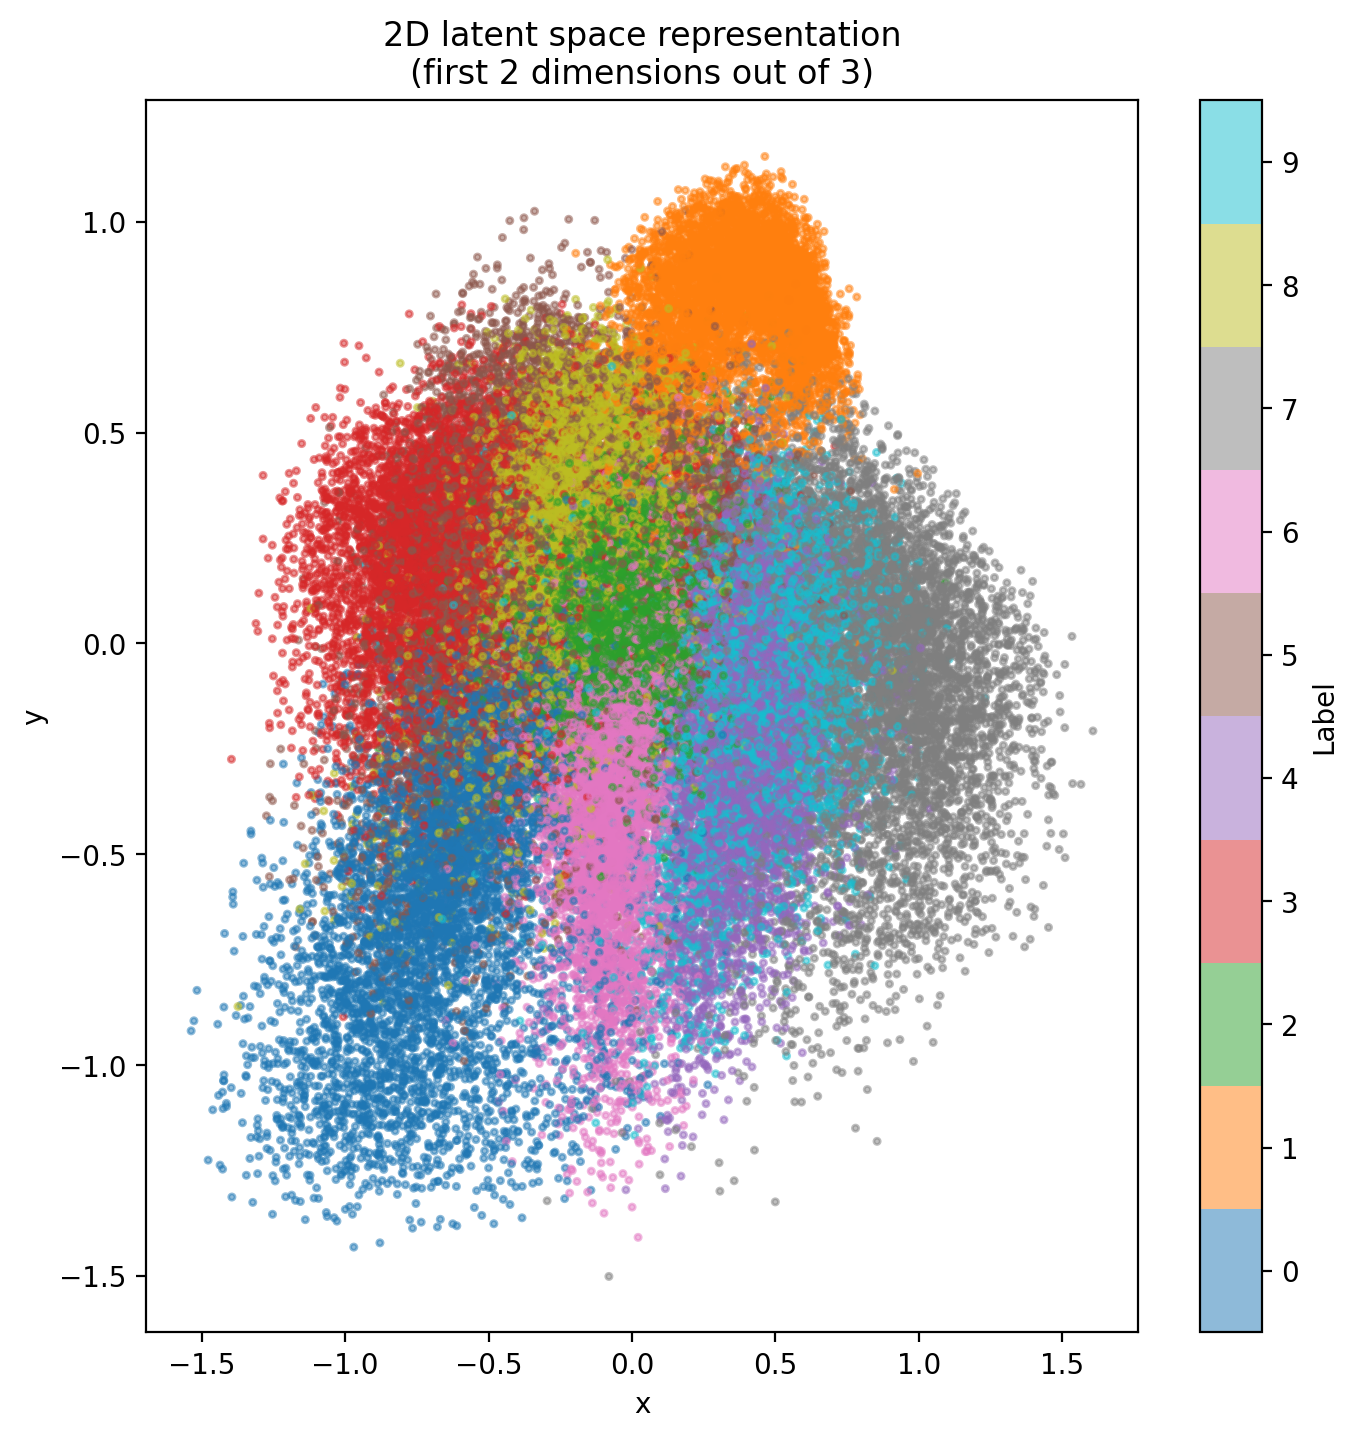

In [24]:
autoencoder.plot_latent()

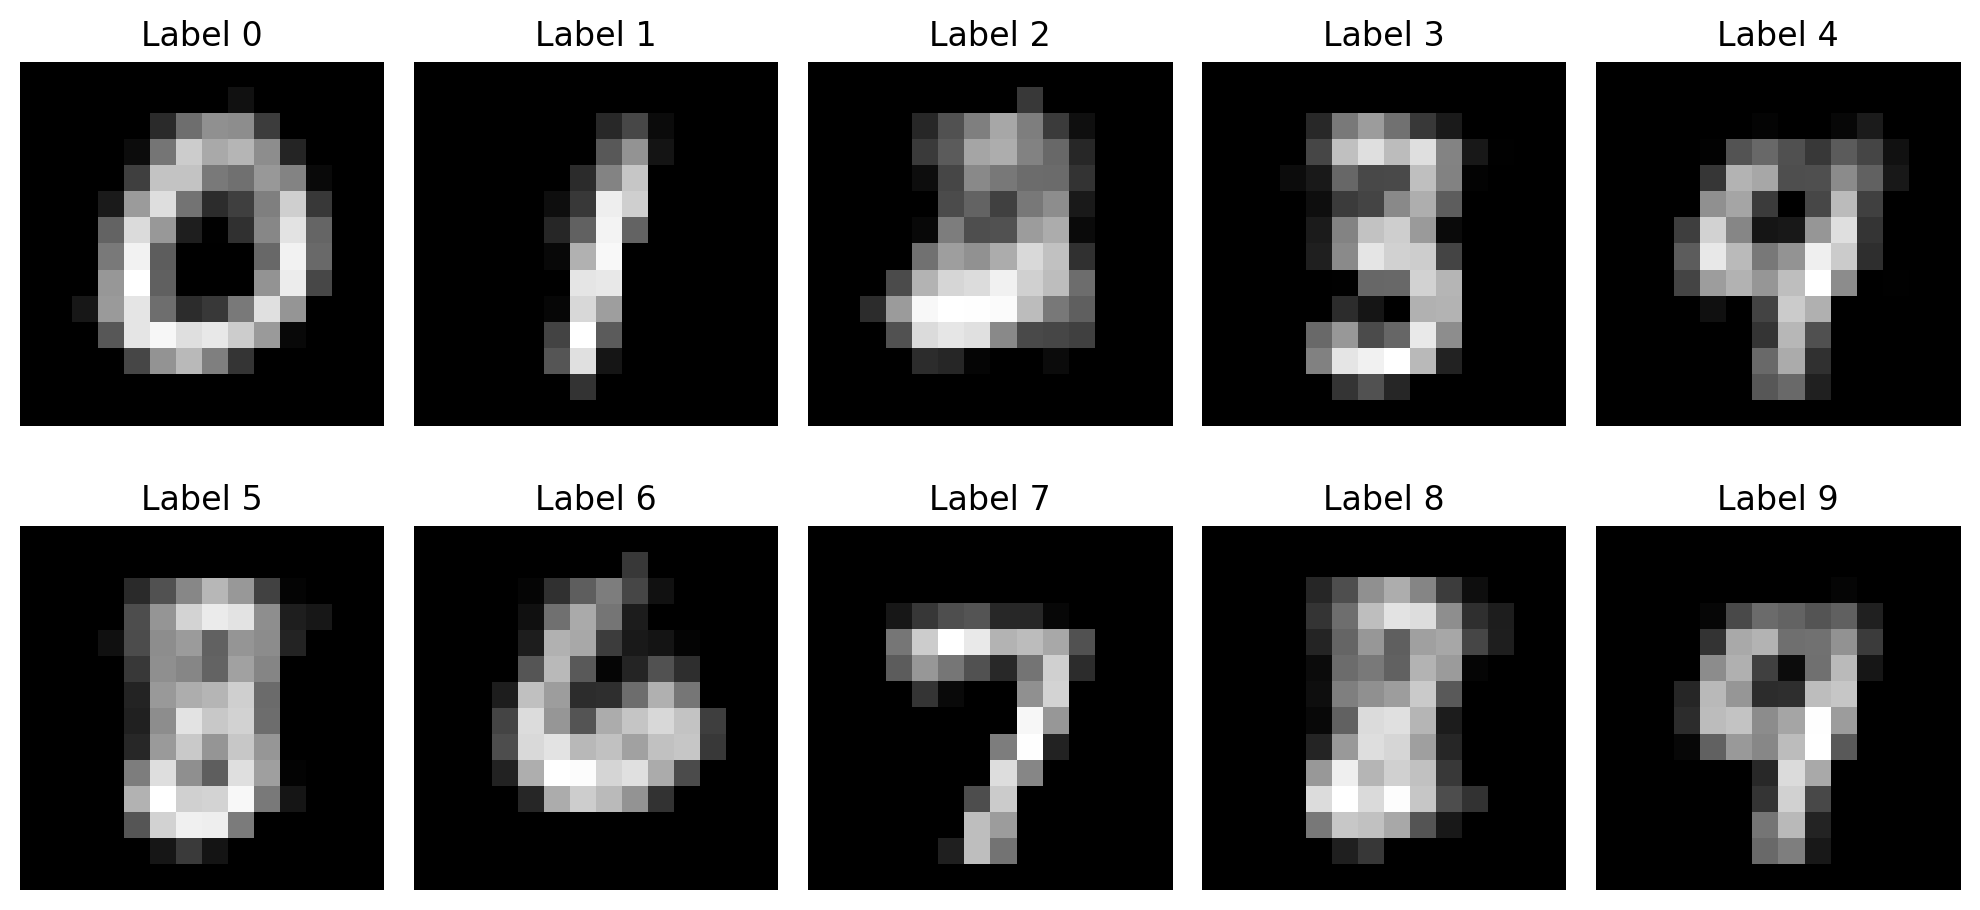

In [25]:
# let's do a 2x5 grid of generated images
plt.figure(figsize=(10, 5), dpi=200)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = autoencoder.generate(i, plot=False)[0]
    plt.imshow(image, cmap='gray')
    plt.title(f"Label {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Variational Autoencoder (VAE)

What si this now? Well this is basically the same as an autoencoder (encode, decode)